In [ ]:
# you only need to run this cell, if data is not present yet
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os, random
from pathlib import Path

from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML

%matplotlib inline


# my imports

from os import listdir
from os.path import isfile, join, abspath
from style_transfer.stylize import transfer



Data Set Overview
==============

Lets first have a look at the rough characterisitcs of our dataset i.e. how large our data set is across the different splits:

In [70]:
dogimages = 'dogImages/'
for path in [os.path.join(dogimages, x) for x in ['train', 'valid', 'test']]:
    sum = 0
    for root, dirs, files in os.walk(path):
        sizes.append(len(files))
        sum += len(files)
    print(f'Number of images in {path} corpus: {sum}')
    

Number of images in dogImages/train corpus: 6680
Number of images in dogImages/valid corpus: 835
Number of images in dogImages/test corpus: 836


Since this capstone project focuses on data augmentation, we want to focus on the train data, that makes the biggest part of our whole dataset. Lets have a look at the class distribution of dog breeds in the training data:

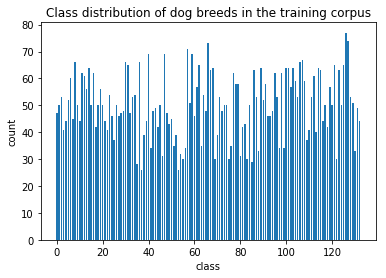

In [71]:
dogimages = 'dogImages/train/'

sizes = []
sum = 0
for root, dirs, files in os.walk(dogimages):
    sizes.append(len(files))
    sum += len(files)

sizes = sizes[1:] # drop the root directory size as it holds no images

plt.bar(range(len(sizes)), sizes, 1/1.5)
plt.title('Class distribution of dog breeds in the training corpus')
plt.xlabel('class')
plt.ylabel('count')
plt.show()


From the above plot we see, that our training data is fairly balanced/uniformly distributed. This justifies our later use of the Accuracy metric (this metric works best, if the class distribution of the dataset is balanced).

Now that we saw some rough insights of our data set, it is time to get a close up: What kind of pictures do we have. 

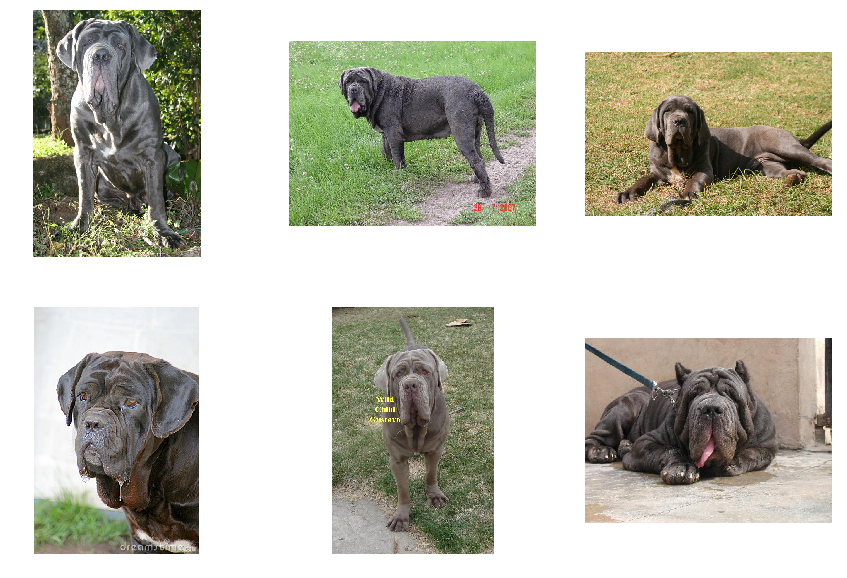

In [85]:
def display_dog_samples(paths, batch):
    '''This method displays an amount of images (batch) that are given via path (paths)'''
    random_samples = random.sample(paths, batch)

    fig = plt.figure(figsize=(15,10)) 
    for path in enumerate(random_samples):
        # Display the image contained in the chosen file.
        img = mpimg.imread(path[1])
        ax = fig.add_subplot(2,3,path[0]+1)
        ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
        plt.axis('off')
    plt.show()
    

training_dirs = [x[0] for x in os.walk(dogimages)]
training_dirs = training_dirs[1:] # ignore root directory

# this yields a random folder for one dog breed in our training corpus
random_dir = random.choice(training_dirs)
image_files = [join(random_dir, f) for f in listdir(random_dir) if isfile(join(random_dir, f))]

display_dog_samples(image_files, 6)

While sampling and displaying a random batch of training data can be helpful it is always recommended, to manually go through a part of the data to get a better understanding. By this I found some interesting pictures:

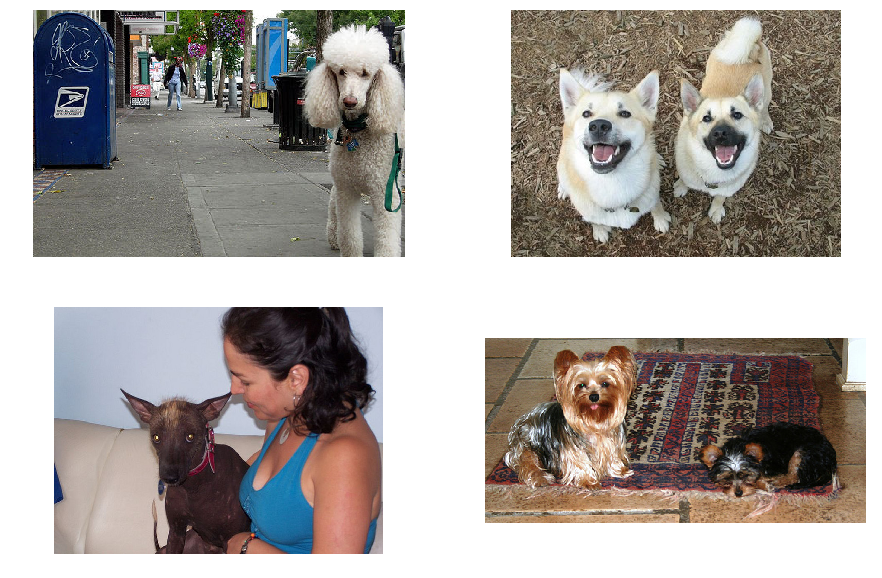

In [91]:
handpicked_pictures = ['dogImages/train/124.Poodle/Poodle_07912.jpg', 'dogImages/train/108.Norwegian_buhund/Norwegian_buhund_07115.jpg', 'dogImages/train/132.Xoloitzcuintli/Xoloitzcuintli_08287.jpg', 'dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08338.jpg']
def plot_sample_pics(paths):
    fig = plt.figure(figsize=(15,10))
    for path in enumerate(paths):
        # Display the image contained in the chosen file.
        img = mpimg.imread(path[1])
        ax = fig.add_subplot(2,2,path[0]+1)
        ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
        plt.axis('off')
    plt.show()
    
plot_sample_pics(handpicked_pictures)


As we see from these example pictures above the dataset is very versatile - even for one class of dog breed! This can be manifested in different backgrounds, multiple dogs on one picture, different angles & sizes of dogs or other objects that are very present (like persons,...). Under these circumstances it does not seem so easy for a CNN to learn a good representation of 'dogs'.

Image Augmentation & Style transfer
============================

Image augmentation is the process of manipulating the raw input data and enrich it with new information. A classical example is the rotation of images - with this augmentation technique the model (i.e. a CNN) is forced to learn a more general representation of an object. Wether a new test images comes in 10 degree or -10 degree rotated does not matter anymore. The CNN is rotation-invariant.
This project is built around a very special augmentation tetchnique: Style transfer.
The aim is to enrich raw images with different styles (texture images). This is, of course, best explained by an example:

![title](notebook_images/dog_style_transfer.png)

The input image from our dog data images data set will be style transferred by different textures (row one).
The result is the same dog with different texture styles applied (row two). Since now different textures are present, but the shape is still the same and recognizable, we enforce the CNN to learn the shape-feature.


The above process uses a technique called `AdaIN style transfer`. How this technique can be applied to raw images will be topic of the next section.

---
## Style transfer

In [90]:
# for the style transfer to work, we first need to download the pretrained models, that AdaIN uses
# and place them into our model directory
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y' -O ./models/vgg_normalised.pth # -P
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w9r1NoYnn7tql1VYG3qDUzkbIks24RBQ' -O ./models/decoder.pth


--2019-08-05 11:58:52--  https://docs.google.com/uc?export=download&id=108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y
Resolving docs.google.com (docs.google.com)... 216.58.208.46, 2a00:1450:4001:815::200e
Connecting to docs.google.com (docs.google.com)|216.58.208.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-c4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/avlgt5mmoqa0nif20t51kis3bomnqlq4/1564999200000/06628786844478210003/*/108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y?e=download [following]
--2019-08-05 11:58:55--  https://doc-08-c4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/avlgt5mmoqa0nif20t51kis3bomnqlq4/1564999200000/06628786844478210003/*/108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y?e=download
Resolving doc-08-c4-docs.googleusercontent.com (doc-08-c4-docs.googleusercontent.com)... 172.217.23.129, 2a00:1450:4001:825::2001
Connecting to doc-08-c4-docs.googleusercontent.com (doc-08-c4-docs.googleu

In [89]:
# our style directory
style_dir = 'texture_images2'

# calculates the number of styles that we will apply on our data
num_styles = len(os.listdir(style_dir))
print(num_styles)
image_folder = 'dogImages'

# Since our data augmentation techniquues will only manipulate the train data,
# we only need that path for now
train_path = os.path.join(image_folder, 'train')


8


Lets have a look at the handpicked textures, that will be applied to our training corpus:

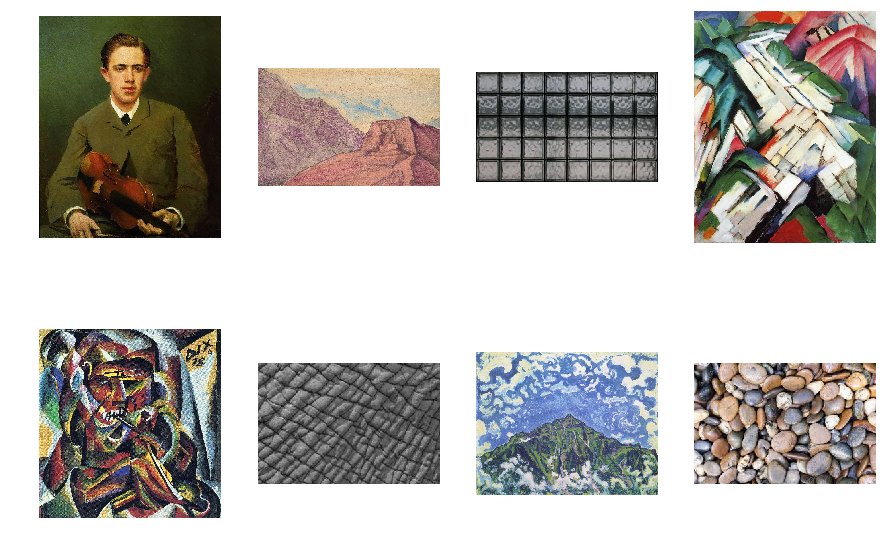

In [100]:
texture_files = [join(style_dir, f) for f in listdir(style_dir) if isfile(join(style_dir, f))]

fig = plt.figure(figsize=(15,10))
for path in enumerate(texture_files):
    # Display the image contained in the chosen file.
    img = mpimg.imread(path[1])
    ax = fig.add_subplot(2,4,path[0]+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

Later we will see how these textures behave in combination with our raw dog images. For that, we first need to set everything up to do the actual style transfer.
**Note**: These are different Texture images as the ones that were presented in the capstone proposal. For justification, please read below.

In the package `style_transfer/stylize.py` I implemented a method called `transfer`. This methods accepts an the target directory (which should be transformed), the stylized images and the output directory. Since our training directory is divided into the many different dog breeds, we first need to get a list to every distinct dog breed folder, that contains the images.
With this list we can then execute our `transfer` function.
**Note**: Much of the code base in `style_transfer` comes from the great open source implementation of AdaIn at https://github.com/naoto0804/pytorch-AdaIN

In [4]:
# create a list of all dog breed folders. We want to style transfer every picture in each folder
train_img_folders = sorted([os.path.join(train_path, path) for path in os.listdir(train_path)])
print(train_img_folders)

['dogImages/train/079.Great_pyrenees', 'dogImages/train/080.Greater_swiss_mountain_dog', 'dogImages/train/081.Greyhound', 'dogImages/train/082.Havanese', 'dogImages/train/083.Ibizan_hound', 'dogImages/train/084.Icelandic_sheepdog', 'dogImages/train/085.Irish_red_and_white_setter', 'dogImages/train/086.Irish_setter', 'dogImages/train/087.Irish_terrier', 'dogImages/train/088.Irish_water_spaniel', 'dogImages/train/089.Irish_wolfhound', 'dogImages/train/090.Italian_greyhound', 'dogImages/train/091.Japanese_chin', 'dogImages/train/092.Keeshond', 'dogImages/train/093.Kerry_blue_terrier', 'dogImages/train/094.Komondor', 'dogImages/train/095.Kuvasz', 'dogImages/train/096.Labrador_retriever', 'dogImages/train/097.Lakeland_terrier', 'dogImages/train/098.Leonberger', 'dogImages/train/099.Lhasa_apso', 'dogImages/train/100.Lowchen', 'dogImages/train/101.Maltese', 'dogImages/train/102.Manchester_terrier', 'dogImages/train/103.Mastiff', 'dogImages/train/104.Miniature_schnauzer', 'dogImages/train/105.

In [3]:
# it is highly recommended to run the following style transfer on a GPU notebook instance! (even then it takes up to 9h)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# transfer the training data and write the data to our new 
for train_content_dir in train_img_folders:
    print(train_content_dir)
    transfer(content_dir=train_content_dir, style_dir=style_dir, output_dir=train_content_dir, num_styles=num_styles)
   

  0%|          | 0/312 [00:00<?, ?it/s]

dogImages/train/113.Old_english_sheepdog
Found 39 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/113.Old_english_sheepdog
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/280 [00:00<?, ?it/s]

dogImages/train/114.Otterhound
Found 35 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/114.Otterhound
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/504 [00:00<?, ?it/s]

dogImages/train/115.Papillon
Found 63 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/115.Papillon
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/240 [00:00<?, ?it/s]

dogImages/train/116.Parson_russell_terrier
Found 30 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/116.Parson_russell_terrier
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/384 [00:00<?, ?it/s]

dogImages/train/117.Pekingese
Found 48 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/117.Pekingese
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/424 [00:00<?, ?it/s]

dogImages/train/118.Pembroke_welsh_corgi
Found 53 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/118.Pembroke_welsh_corgi
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/248 [00:00<?, ?it/s]

dogImages/train/119.Petit_basset_griffon_vendeen
Found 31 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/119.Petit_basset_griffon_vendeen
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/312 [00:00<?, ?it/s]

dogImages/train/120.Pharaoh_hound
Found 39 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/120.Pharaoh_hound
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/224 [00:00<?, ?it/s]

dogImages/train/121.Plott
Found 28 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/121.Plott
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/256 [00:00<?, ?it/s]

dogImages/train/122.Pointer
Found 32 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/122.Pointer
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/352 [00:00<?, ?it/s]

dogImages/train/123.Pomeranian
Found 44 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/123.Pomeranian
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/400 [00:00<?, ?it/s]

dogImages/train/124.Poodle
Found 50 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/124.Poodle
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/272 [00:00<?, ?it/s]

dogImages/train/125.Portuguese_water_dog
Found 34 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/125.Portuguese_water_dog
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/240 [00:00<?, ?it/s]

dogImages/train/126.Saint_bernard
Found 30 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/126.Saint_bernard
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/328 [00:00<?, ?it/s]

dogImages/train/127.Silky_terrier
Found 41 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/127.Silky_terrier
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/240 [00:00<?, ?it/s]

dogImages/train/128.Smooth_fox_terrier
Found 30 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/128.Smooth_fox_terrier
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/384 [00:00<?, ?it/s]

dogImages/train/129.Tibetan_mastiff
Found 48 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/129.Tibetan_mastiff
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/352 [00:00<?, ?it/s]

dogImages/train/130.Welsh_springer_spaniel
Found 44 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/130.Welsh_springer_spaniel
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/240 [00:00<?, ?it/s]

dogImages/train/131.Wirehaired_pointing_griffon
Found 30 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/131.Wirehaired_pointing_griffon
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/208 [00:00<?, ?it/s]

dogImages/train/132.Xoloitzcuintli
Found 26 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/132.Xoloitzcuintli
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


  0%|          | 0/240 [00:00<?, ?it/s]

dogImages/train/133.Yorkshire_terrier
Found 30 content images in /home/ec2-user/SageMaker/cnn-classifier/dogImages/train/133.Yorkshire_terrier
Found 8 style images in /home/ec2-user/SageMaker/cnn-classifier/texture_images2


100%|██████████| 240/240 [01:41<00:00,  2.44it/s]


In [6]:
# rename the style transferred images, so that we have no conflicts with the original ones (for baseline testing)
!mv dogImages dogImages_style_transfer

In [95]:
# our transferred dataset is about 4 times bigger than our original one! That data crunching will take some time...
!du -sh *

3.1M	dog-breed-data-exploration.ipynb
1.7M	dog-breed-pytorch-training.ipynb
40K	dog-breed-sagemaker-deployment.ipynb
40K	dog-breed-sagemaker-deployment-style-transfer.ipynb
1.1G	dogImages
4.7G	dogImages_style_transfer
1.1G	dogImages.zip
4.0K	environment.yml
4.0K	LICENSE
90M	models
1.3M	notebook_images
4.0K	README.md
4.0K	requirements.txt
48K	source_pytorch
48K	source_pytorch_style_transfer
120K	style_transfer
380K	texture_images
4.5M	texture_images2
12K	windows.jpeg


Now we can again have a look at our image data - this time the style transferred one!

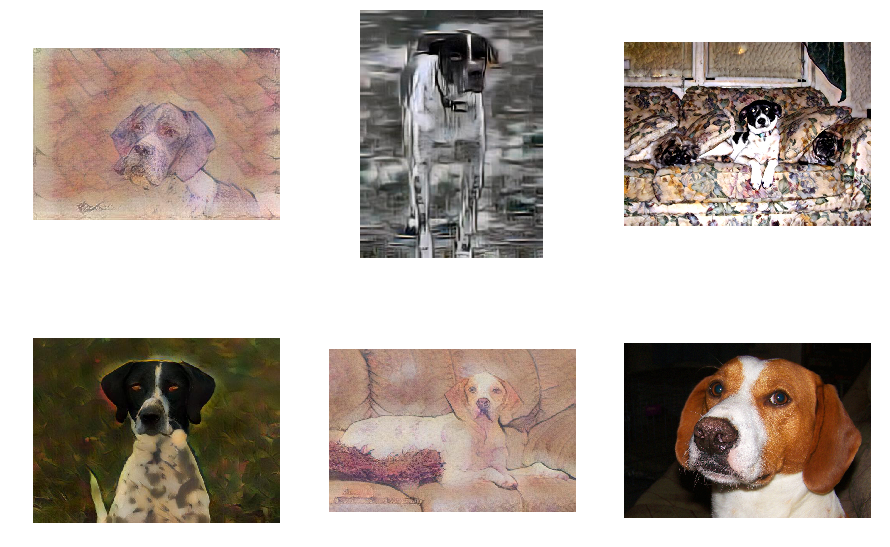

In [99]:
aug_dogimages = 'dogImages_style_transfer/train/'
aug_training_dirs = [x[0] for x in os.walk(aug_dogimages)]
aug_training_dirs = aug_training_dirs[1:] # ignore root directory

# this yields a random folder for one dog breed in our training corpus
random_dir = random.choice(aug_training_dirs)
image_files = [join(random_dir, f) for f in listdir(random_dir) if isfile(join(random_dir, f))]

display_dog_samples(image_files, 6)

The above sample impressively shows how the style/texture images are applied to the raw images. These textures amplify the object/dog shapes clearly. Hence, our preprocessing with these textures in combination with style transfer looks very promising.  **Note**: We of course also include the raw images (see the right cornor on the bottom)

**Justification**: My texture images that were included with my capstone proposal were different, from the ones that I actually used during the project. The most important reason is, that these textures did not really highlight the shape of objects/dogs. Because of this I chose new texture images, from the same dataset where also the original paper sampled from. You can find that dataset at https://www.kaggle.com/c/painter-by-numbers/data 

The following pictures were created with the old texture images. You see how often times the dogs shape is barely recognizable (even for us humans). This makes it very hard for CNNs to learn a proper representation:

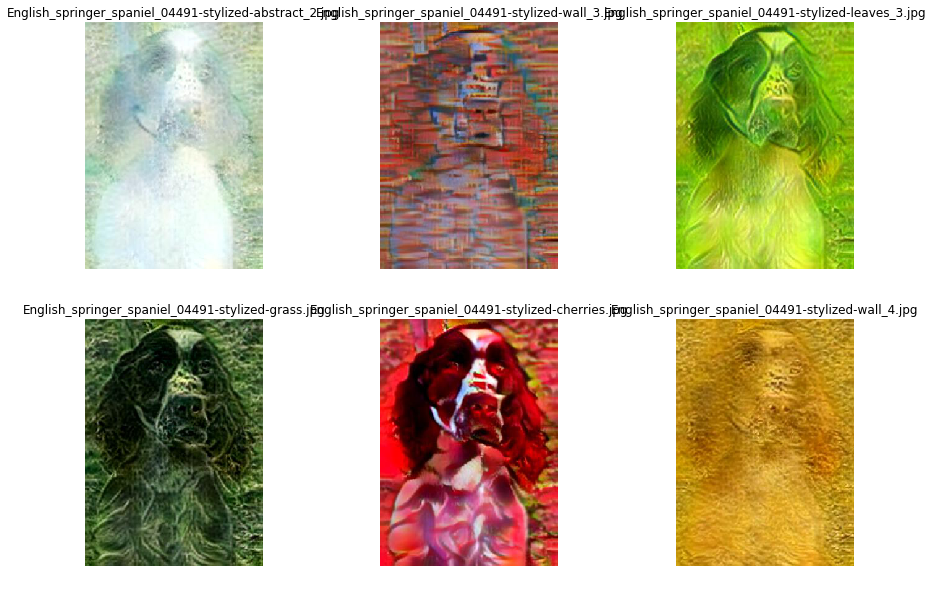

## Advanced Preprocessing

In later notebooks, we see how we define further data transformations with the `PyTorch` framework. While the `torchvision.transforms` package has lots of useful and important pre-processing capabilities (like `Resize`, `CenterCrop`,...) it lacks capabilities of advanced image augmentation.
After some research I stumbeled upon a great library called `imgaug` that leverages some advanced image processing techniques.


While this is all possible in a local notebook, we should always focus that it is also possible in the managed AWS SageMaker instance. For this, we need to specify the dependencies in `requirements.txt` of our training container (details in the PyTorch training folders).

First we will need to install `imgaug` via `pip`

In [1]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-1n632xkq
    100% |████████████████████████████████| 1.5MB 20.5MB/s ta 0:00:01
    100% |████████████████████████████████| 20.0MB 2.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for imgaug ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-j2kvxfrb/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
fastai 1.0.52 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Next, lets apply some of the advanced image augmentation techniques to some sample pictures:

`imgaug` has capabilities to for edge detection. This feature seems very promising for our task at hand, because edges define the shape of an objectt. And the shape of an object is the characteristic we want our CNN to focus on. With `imgaug` we can easily lay an edge detector on our images:

Original:


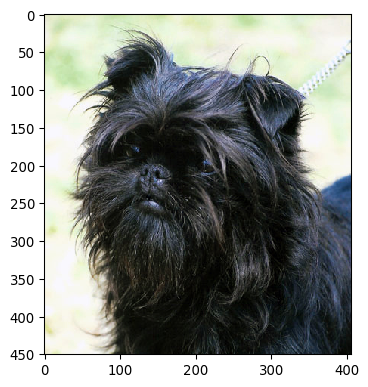

Augmented:


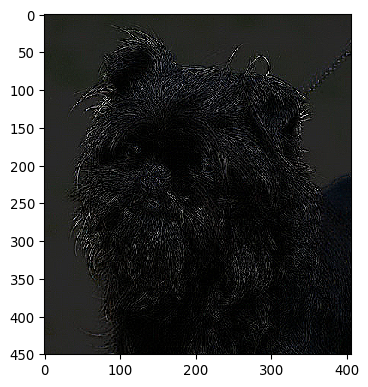

In [45]:
import imageio

image = imageio.imread("dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg")

print("Original:")
ia.imshow(image)

rotate = iaa.EdgeDetect(alpha=(0.8, 1.0))
image_aug = rotate.augment_image(image)



print("Edge detector:")
ia.imshow(image_aug)

Furthermore, it is possible to specify complex pipelines with `Sequential`, where some operations are only executed sometimes. For this, have a look at the following class:

In [46]:
import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 100, 150

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

# sadly the library does have GPU support as of now
class AdvancedAugmentation:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
        # blur images with a sigma of 0 to 3.0
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        # horizontally flip 50% of the images
        iaa.Fliplr(0.5),
        # rotate by -20 to +20 degrees. The default mode is 'constant' which displays a constant value where the
        # picture was 'rotated out'. A better mode is 'symmetric' which 
        #'Pads with the reflection of the vector mirrored along the edge of the array' (see docs) 
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        # do edge detection on 25% of the pictures
        iaa.Sometimes(0.25,
                      iaa.EdgeDetect(alpha=(0.5, 1.0))),
    ])
      
  def __call__(self, img):
    img = np.array(img)

    '''
    # This is a experimental try to get even more shape
    # informations via imgaug heatmap feature.
    # While this code works, I could not find out how
    # to create custom heatmaps (not the quoakka_heatmap) for our images

    heatmap = ia.quokka_heatmap(size=0.25)
    print(f'img shape via heatmap.shape {heatmap.shape}')
    print(f'img shape {img.shape}')
    image_aug, heatmap_aug = self.aug(image=img, heatmaps=heatmap)
    return np.hstack([image_aug, heatmap_aug.draw(cmap="gray")[0]])
    
    '''

    # either return a PIL.Image here or use PyTorch Lambda transform later on
    # return PIL.Image.fromarray(self.aug.augment_image(img))    
    return self.aug.augment_image(img)
    

This pipeline character reminds me a lot of `torchvision.transforms` and indeed we can combine them! This is also necessary since we want to do our training with PyTorch later on with AWS SageMaker.

In [47]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        AdvancedAugmentation(),
        # this lambda expression is quite important as it transforms the output of imgaug library to a format
        # that our torchvision.transforms steps can pick up
        torchvision.transforms.Lambda(lambda x: PIL.Image.fromarray(x)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [50]:
data_dir = 'dogImages/'

image_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
# ATTENTION: WE NEED TO SET num_workers to 0! Otherwise we will run into errors
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=8, shuffle=True, num_workers=0)


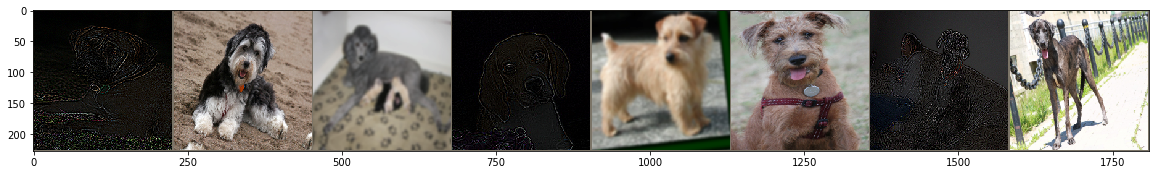

In [53]:
# use a generic method to display a numpy array
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize = (20,6))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


# get one batch from our dataloader
inputs, classes = next(iter(dataloaders))
#inputs, classes = next(iter(dataloader))

# transform the batch into a grid
out = torchvision.utils.make_grid(inputs)

imshow(out)

In the above image we see, that our batch of 8 pictures only gets augmented with an edge detectore sometimes. That is exactly what we specified above. Nice!